In [53]:
from Simulation_PyAPDL import simulation_PyAPDL
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr
from SALib.analyze import sobol
from SALib.sample import sobol as sobol_sample


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]

    if len(filtered_data) == 0:
        filtered_data = data
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

def find_max_cluster(data):
    # Reshape for clustering
    data_reshaped = data.reshape(-1, 1)
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=1, min_samples=2).fit(data_reshaped)
    # Get cluster labels
    labels = db.labels_
    # Identify the largest cluster
    largest_cluster = mode(labels[labels != -1])[0][0]  # Exclude noise (-1)
    # Get values in the largest cluster
    return data[labels == largest_cluster]


## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp

def split_data_limit_corr(input_X, input_Y, max_corr = 0.2, num_trial = 2000, test_size_ = 0.1, random_seed = None):
    for i_test in range(num_trial):
        bool_high_corr = False
        # Split into training and test sets
        if random_seed is None:
            seed = np.random.randint(0, 1000000)
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state=seed)

            # Compute Pearson and Spearman correlations for each feature
            correlations = []
            for i in range(input_X.shape[1]):
                pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
                spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
                correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))
                if np.abs(pearson_corr) >= max_corr:
                    bool_high_corr = True
                    break

            if bool_high_corr:
                if i_test == num_trial-1:
                    print("Failed split data")
                continue
            else:
                print("Succesfully split data")
                print(f"Random seed {seed}")
                df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
                print(df)
                return X_train, X_test, y_train, y_test
        else:
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state = random_seed)
            return X_train, X_test, y_train, y_test
        

def sobol_GSA(gpr_model,num_var, sample_size = 2048, var_name = [], plot_ = False):
    # Define the problem (bounds of the input parameters)
    if var_name == []:
        problem = {
            'num_vars': 19,  # Number of parameters
            'names': ['param_{}'.format(i) for i in range(1, num_var+1)],  # Parameter names
            'bounds': [(0, 1)] * 19  # Parameter bounds, here [0, 1] for each
        }
    else:
        problem = {
            'num_vars': num_var,  # Number of parameters
            'names': [var_name[i] for i in range(0, num_var)],  # Parameter names
            'bounds': [(0, 1)] * num_var  # Parameter bounds, here [0, 1] for each
        }
    # Generate Sobol samples
    param_values = sobol_sample.sample(problem, sample_size)  
    Y = gpr_model.predict(param_values)
    # Perform Sobol analysis on the GP model's predictions
    Si = sobol.analyze(problem, Y, print_to_console=True)

    if plot_:
        # Create a figure and axis object
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot First-order Sobol indices (S1) on the left y-axis
        width = 0.35  # Width of the bars
        ax1.bar(var_name, Si['S1'], color='blue', label='First-order Sobol', alpha=0.7, width=width)
        ax1.set_xlabel('Parameters')
        ax1.set_ylabel('First-order Sobol indices', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_xticklabels(var_name, rotation=90)

        # Create the second y-axis for Total Sobol indices (ST)
        ax2 = ax1.twinx()
        ax2.bar(var_name, Si['ST'], color='lightcoral', label='Total Sobol', alpha=0.7, width=width, align='edge')
        ax2.set_ylabel('Total Sobol indices', color='lightcoral')
        ax2.tick_params(axis='y', labelcolor='lightcoral')

        # Align the bars by adjusting the y-limits to the same range
        y_min = min(min(Si['S1']), min(Si['ST']))
        y_max = max(max(Si['S1']), max(Si['ST']))
        ax1.set_ylim([y_min-0.05, y_max+0.1])
        ax2.set_ylim([y_min-0.05, y_max+0.1])
        # Set title and adjust layout
        plt.title('First-order and Total Sobol indices (Sensitivity Analysis)')
        plt.tight_layout()

        # Show the plot
        plt.show()
        
    return Si

In [29]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,18):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.9830062917349182, NMSE: 0.016993708265081814
gpr_fn2_ex22 performace: R² Score: 0.9868129191068415, NMSE: 0.013187080893158438


                ST   ST_conf
t_sl      0.200049  0.015436
t_cor     0.002956  0.000333
t_g       0.001219  0.000141
t_ew      0.050274  0.003661
t_iw      0.008968  0.000879
e_sl      0.145672  0.010450
e_cor     0.001283  0.000161
e_g       0.002107  0.000198
e_ew      0.030897  0.002809
e_iw      0.007827  0.000835
rho_sl    0.491347  0.028021
rho_cor   0.001733  0.000188
rho_g     0.001209  0.000150
rho_ew    0.001812  0.000175
rho_iw    0.001440  0.000173
soil_vs   0.045681  0.004580
soil_rho  0.014467  0.001533
heig      0.037103  0.003326
DampR     0.000928  0.000113
                S1   S1_conf
t_sl      0.172588  0.024338
t_cor     0.001587  0.003650
t_g      -0.000732  0.002128
t_ew      0.047450  0.012001
t_iw      0.009452  0.006393
e_sl      0.135009  0.024219
e_cor     0.001093  0.002008
e_g       0.001642  0.002931
e_ew      0.026344  0.009939
e_iw      0.004309  0.005321
rho_sl    0.477699  0.036715
rho_cor  -0.000065  0.002646
rho_g     0.000812  0.001943
rho_ew   -0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_27396\1926917450.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


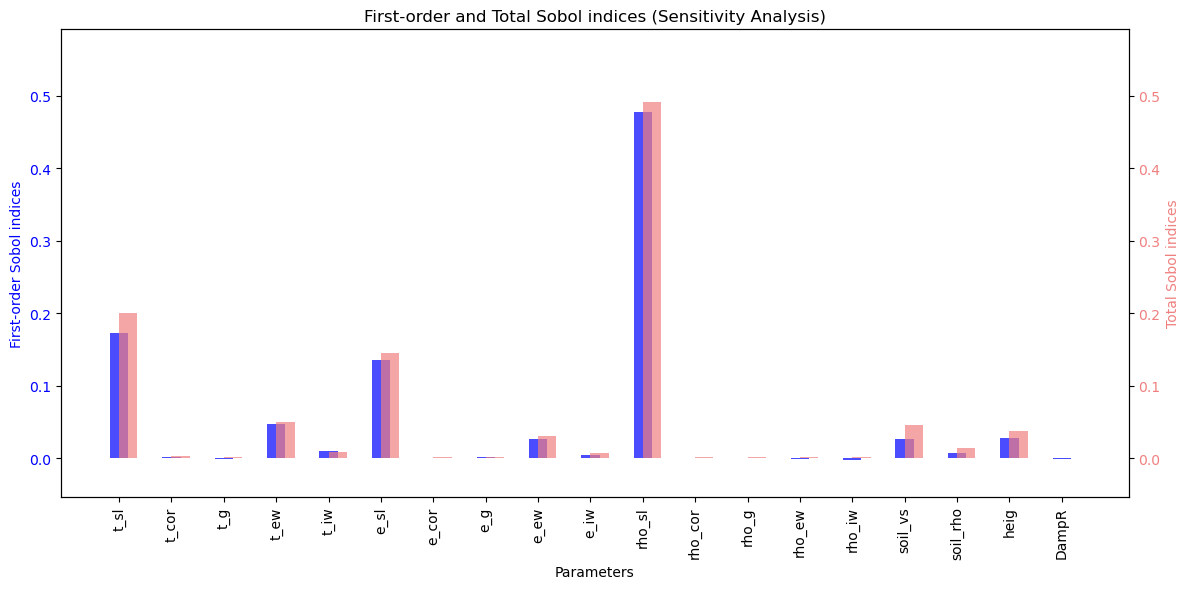

First-order Sobol indices: [ 1.72587965e-01  1.58694672e-03 -7.31554416e-04  4.74501945e-02
  9.45208147e-03  1.35008676e-01  1.09253658e-03  1.64209395e-03
  2.63437260e-02  4.30903447e-03  4.77698511e-01 -6.47345764e-05
  8.12240797e-04 -1.28079921e-03 -2.74503863e-03  2.72352444e-02
  7.41539639e-03  2.73463971e-02 -4.88586217e-04]
Total Sobol indices: [0.20004913 0.00295628 0.00121889 0.05027402 0.00896808 0.14567188
 0.00128348 0.0021073  0.03089662 0.00782725 0.49134697 0.00173347
 0.00120916 0.00181163 0.00143954 0.04568149 0.01446682 0.03710326
 0.0009279 ]


In [54]:
import numpy as np
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol


input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
Si = sobol_GSA(gpr_fn1_ex22,19,2048,input_name,True)

# Output Sobol indices
print("First-order Sobol indices:", Si['S1'])
print("Total Sobol indices:", Si['ST'])



